### Курсовая работа
#### Прудникова Анастасия М8О-114СВ-24

Датасет Chest X-Ray Images предназначен для выявления пневмонии на рентгеновских снимках грудной клетки. Он включает в себя два класса изображений:

NORMAL — снимки без признаков пневмонии.
PNEUMONIA — снимки с диагностированной пневмонией

In [ ]:
import os
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from lime import lime_image
from skimage.segmentation import mark_boundaries

from torchvision import datasets, transforms, models
import torch.nn as nn
import torch.optim as optim

In [ ]:
# !curl -L -o chest-xray-pneumonia.zip https://www.kaggle.com/api/v1/datasets/download/paultimothymooney/chest-xray-pneumonia
# !unzip chest-xray-pneumonia.zip -d chest-xray-pneumonia

In [6]:
data_dir = "chest_xray/chest_xray" 

In [58]:
img_path = os.path.join(data_dir, "val/PNEUMONIA", os.listdir(os.path.join(data_dir, "val/PNEUMONIA"))[1])

img = Image.open(img_path).convert("RGB")

In [59]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [60]:
input_tensor = transform(img).unsqueeze(0)

model = torchvision.models.resnet18(pretrained=True)
model.fc = torch.nn.Linear(model.fc.in_features, 2)
model.eval()

class_names = ["NORMAL", "PNEUMONIA"]

c:\Users\nprud\Desktop\MAI\MAI\.conda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\nprud\Desktop\MAI\MAI\.conda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [61]:
def batch_predict(images):
    model.eval()
    batch = torch.stack([transform(Image.fromarray(img).convert("RGB")) for img in images], dim=0)
    with torch.no_grad():
        logits = model(batch)
        probs = torch.nn.functional.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

In [62]:
explainer = lime_image.LimeImageExplainer()

explanation = explainer.explain_instance(
    np.array(img.resize((224, 224))),
    batch_predict,
    top_labels=2,
    hide_color=0,
    num_samples=1000
)


  0%|          | 0/1000 [00:00<?, ?it/s]

In [63]:
temp, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[0],
    positive_only=True,
    hide_rest=False,
    num_features=5,
    min_weight=0.0
)

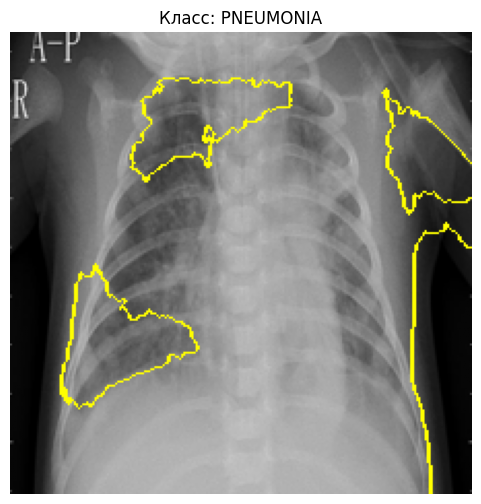

In [64]:
plt.figure(figsize=(6, 6))
plt.imshow(mark_boundaries(temp / 255.0, mask))
plt.title(f"Класс: {class_names[explanation.top_labels[0]]}")
plt.axis('off')
plt.show()
